In [2]:
import numpy as np
import matplotlib.pyplot as plt

# The depth encoder

The cell below contains the key function for creating autostereograms. It encodes an array of **3D depths** to an array of **pixel offsets** that encode those depths.

You can adapt this function to your own work, or examine the rest of the notebook for a demonstration of how it works.

In [116]:
def encodeDepthInColumnOffsets(depthArr, columnWidth):
    """
    Arguments:
        depthArr: A 2D array of pixels encoding the 3D depths you want viewers to see. (Positive depth = "coming out of the page")
        columnWidth: The width (in pixels) of the repeating pattern in the base image.
            - In other words, it is required that `baseImage[row, col] = baseImage[row, col + columnWidth]`
        
    """
    rows, cols = depthArr.shape
    colOffsetArr = np.zeros([rows, cols + columnWidth])
    
    # For each row of pixels...
    for row in range(depthArr.shape[0]):
        
        # For each column in that row...
        for col in range(depthArr.shape[1]):
            
            # Get the current depth to encode
            currDepth = depthArr[row, col]
            
            # Get the offset of the equivalent pixel from the previous column
            prevOffsetCol = col - columnWidth//2 + int(currDepth)
            prevOffsetCol = np.clip(prevOffsetCol, 0, colOffsetArr.shape[1]) # (ensures it's in bounds)
            prevOffset = colOffsetArr[row, prevOffsetCol]
            
            # This pixel's offset = its offset from the prev. column + the current depth to encode
            # (This step is where we assume a linear mapping between "depths" and "offsets")
            colOffsetArr[row, col + columnWidth//2] = currDepth + prevOffset
        
        colOffsetArr[row,:] -= np.mean(colOffsetArr[row,:])
    return colOffsetArr


# -- Below: literally the exact same function as above, but in way fewer lines --

def encodeDepthInColumnOffsetsCondensed(depthArr, columnWidth):
    colOffsetArr = np.zeros([depthArr.shape[0], depthArr.shape[1]+columnWidth])
    for row in range(depthArr.shape[0]):
        for col in range(depthArr.shape[1]):
            currDepth = depthArr[row, col]
            prevOffset = colOffsetArr[row, np.clip(col-columnWidth//2+int(currDepth), 0, colOffsetArr.shape[1])]
            colOffsetArr[row, col+columnWidth//2] = prevOffset + currDepth
        colOffsetArr[row,:] -= np.mean(colOffsetArr[row,:])
    return colOffsetArr

---

# Demo part 1: Generating a simple base image

This code generates a vertical stripe containing a "pile" of semi-transparent, randomly generated polygons. It then tiles this vertical stripe N times to make an N column base image.

In [3]:
# -- Polygon geometry functions --
# (I did this by hand for a different exercise, and it was easier to cross-port those functions
# than to learn to use a library)

def getRegPoly(n_edges, radius, theta):
    thetas = np.linspace(0, 2*np.pi, n_edges+1) + theta
    return radius*np.cos(thetas), radius*np.sin(thetas)
    
def getRandomRegPoly(n_edges_list=[3,4,5,6], radiusBounds=[0,1]):
    return getRegPoly(np.random.choice(n_edges_list), np.random.uniform(*radiusBounds), np.random.uniform(0, 2*np.pi))

def isBetween(val, bounds): return np.sign(val-bounds[0]) * np.sign(val-bounds[1]) == -1

def getLeftRight(segX, segY, x, y):
    # Returns 1 if segment (segX, segY) passes left->right past point (x,y), -1 if right->left, 0 if x is outside segX bounds
    return np.sign(segX[1]-segX[0]) * isBetween(x, segX)

def getOverUnder(segX, segY, x, y):
    # Returns 1 if point (x,y) is above the line defined by (segX, segY), -1 if below, 0 otherwise
    relX, relY = x - segX[0], y - segY[0]
    segRelX, segRelY = segX[1] - segX[0], segY[1] - segY[0]
    mPoint, mSeg = relY/relX, segRelY/segRelX
    overUnderVals = np.sign(mPoint - mSeg) * np.sign(segRelX)
    overUnderVals[np.isnan(overUnderVals)] = 0
    return overUnderVals

def isPointInPoly(polyX, polyY, x, y):
    # Returns true if point (x,y) is contained within the polygon, else false
    n = len(polyX)-1
    segXArr = np.array([(polyX[i], polyX[(i+1)]) for i in range(n)])
    segYArr = np.array([(polyY[i], polyY[(i+1)]) for i in range(n)])
    leftRightArr = np.array([getLeftRight(segX, segY, x, y) for (segX, segY) in zip(segXArr, segYArr)])
    overUnderArr = np.array([getOverUnder(segX, segY, x, y) for (segX, segY) in zip(segXArr, segYArr)])
    return np.sum(leftRightArr * overUnderArr, axis=0) != 0

In [4]:
# -- Functions for creating the base image --

def getPixArr(bounds, npix):
    delta = (bounds[1]-bounds[0])/(npix)
    return np.linspace(bounds[0], bounds[1]-delta, npix) + (0.5*delta)

def getCondInPoly(imgArr, imgCoordsXY, polyX, polyY, xWrap=1):
    condInPoly = isPointInPoly(polyX, polyY, imgCoordsXY[:,:,0], imgCoordsXY[:,:,1])
    if xWrap:
        condInPoly |= isPointInPoly(polyX-xWrap, polyY, imgCoordsXY[:,:,0], imgCoordsXY[:,:,1])
        condInPoly |= isPointInPoly(polyX+xWrap, polyY, imgCoordsXY[:,:,0], imgCoordsXY[:,:,1])  
    return condInPoly

def updateColors(imgArr, imgCoordsXY, polyX, polyY, rgb, alpha, xWrap=1):
    condInPoly = getCondInPoly(imgArr, imgCoordsXY, polyX, polyY)
    imgArr[condInPoly.T,:] = imgArr[condInPoly.T,:]*(1-alpha) + rgb*alpha
    
def tileAndTransformImgArr(imgArr, nTile):
    return np.tile(imgArr.transpose(1,2,0), nTile).transpose(0,2,1)


In [5]:
# -- Generates the base image --
# (This is extremely slow atm; a better `getCondInPoly` function could speed it up)

nPoly = 1200
xBounds = (0,1)
yBounds = (0,5)
xRange, yRange = (xBounds[1]-xBounds[0]), (yBounds[1]-yBounds[0])
imgPixPerUnit = 250
rgbs = [
    np.array([1,0,0]),
    np.array([0,1,0]),
    np.array([0,0.5,1]),
    np.array([1,1,0])*.8,
    np.array([0,1,1])*.8,
    np.array([1,0,1])*.8
]
alpha = 0.3
tileNum = 10

xPix, yPix = imgPixPerUnit*xRange, imgPixPerUnit*yRange
imgCoordsX1d = getPixArr(xBounds, xPix)
imgCoordsY1d = getPixArr(yBounds, yPix)
imgCoordsXY = np.dstack(np.meshgrid(imgCoordsX1d, imgCoordsY1d))    
imgArr = np.ones((xPix, yPix, 3))

for i in range(nPoly):
    print(i, end='\r')
    offsetX, offsetY = np.random.uniform(*xBounds), np.random.uniform(*yBounds)
    polyX, polyY = getRandomRegPoly(radiusBounds=[0.02,0.4])
    rgb = rgbs[np.random.randint(len(rgbs))]
    updateColors(imgArr, imgCoordsXY, polyX+offsetX, polyY+offsetY, rgb, 0.5)


imgArr = tileAndTransformImgArr(imgArr, tileNum)

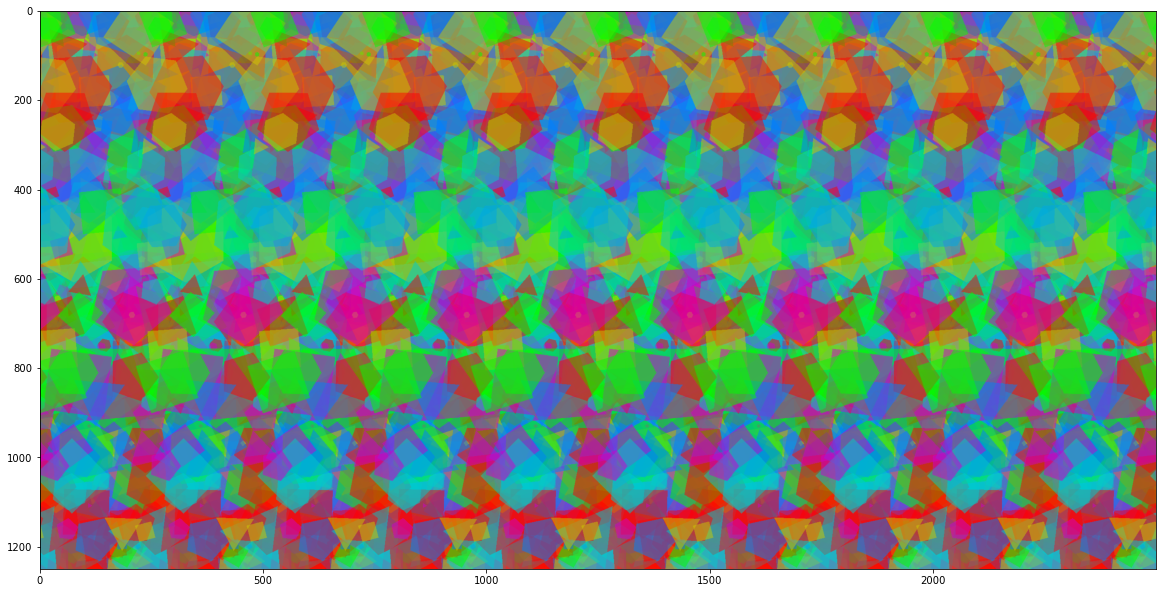

In [26]:
plt.figure(figsize=(20,20))
plt.imshow(imgArr)
plt.show()

---

# Demo part 2: Creating the autostereogram

Here, the code takes an aribtrary array of "depth" (the 3D height that you want viewers to see) and encodes it in "pixel offsets" (the distance between pixels in one column to pixels in the next). This encoding creates the autostereogram illusion.

I've included the code I used to generate the depth map of Saturn, but basically any depth map (in fact, any grayscale image!) will work just fine.

In [111]:
# -- Remaps an array of color values to a new set of pixels --
# There is definitely an existing library to do this, but this is good enough for the current case

def imgValAtVectorized(imgArr, xArr, yArr, nColorbands=3):
    infs = 0.0001 # The code breaks if x or y exactly equals the max pixel :/
    xMax, yMax = imgArr.shape[:2]
    x, y = np.clip(xArr, 0, xMax-1-infs), np.clip(yArr, 0, yMax-1-infs)
    
    # Drop a pixel-size square at x,y and average the colors that fall within it
    xLower, yLower = x.astype(int), y.astype(int)
    xUpper, yUpper = xLower, yLower
    xLowerFrac, yLowerFrac = x%1., y%1.
    xUpperFrac, yUpperFrac = 1-xLowerFrac, 1-yLowerFrac
    
    # Manually match the dimensions in the "colorbands" dimension, bc numpy is a real jerk about it if you don't
    if nColorbands > 1:
        xLowerFrac, yLowerFrac = np.dstack([xLowerFrac]*nColorbands), np.dstack([yLowerFrac]*nColorbands)
        xUpperFrac, yUpperFrac = np.dstack([xUpperFrac]*nColorbands), np.dstack([yUpperFrac]*nColorbands)
    
    return (
        imgArr[xLower, yLower] * xLowerFrac*yLowerFrac +
        imgArr[xLower, yUpper] * xLowerFrac*yUpperFrac +
        imgArr[xUpper, yLower] * xUpperFrac*yLowerFrac +
        imgArr[xUpper, yUpper] * xUpperFrac*yUpperFrac
    )

In [112]:
# -- Image transform code --
# Used for loading in the rocket image

from matplotlib import image

def resize(img, factor):
    xIndices, yIndices = np.indices(img.shape)
    newXSize, newYSize = int(img.shape[0]*factor), int(img.shape[1]*factor)
    newXIndices, newYIndices = np.indices((newXSize, newYSize)) / factor
    return imgValAtVectorized(img, newXIndices, newYIndices, nColorbands=1)

def rotate(img, theta):
    xIndices, yIndices = np.indices(img.shape)
    xCtr, yCtr = img.shape[0]//2, img.shape[1]//2
    xIndicesRot = (xIndices-xCtr)*np.cos(theta) - (yIndices-yCtr)*np.sin(theta)
    yIndicesRot = (yIndices-yCtr)*np.cos(theta) + (xIndices-xCtr)*np.sin(theta)
    xIndicesRot += xCtr
    yIndicesRot += yCtr
    return imgValAtVectorized(img, xIndicesRot, yIndicesRot, nColorbands=1)    

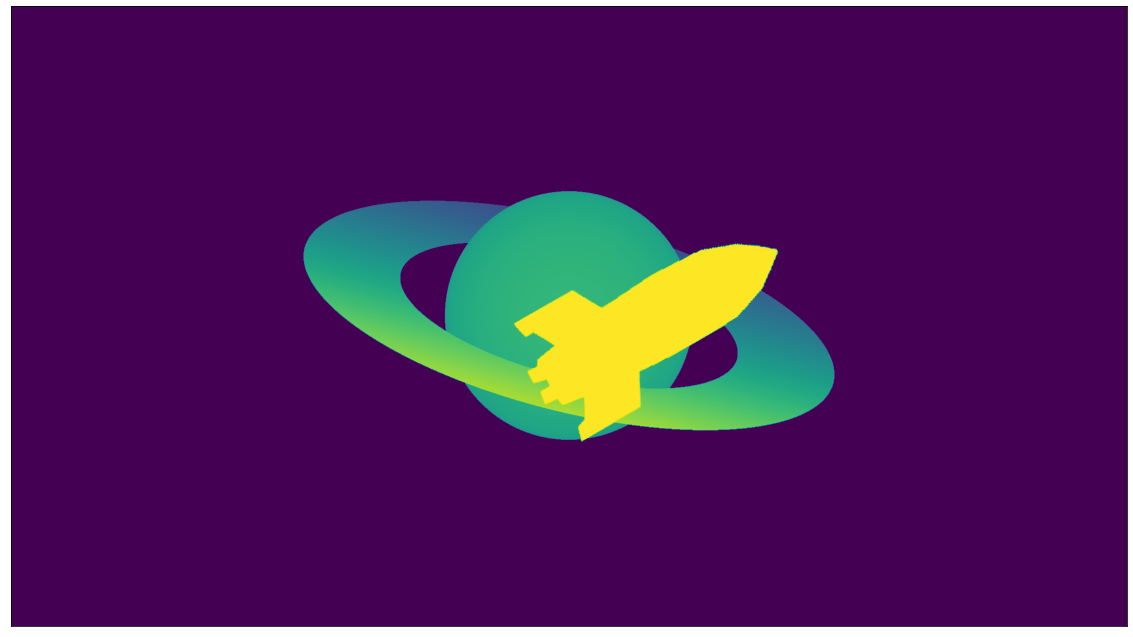

In [113]:
# -- Creates the depth map --

import warnings
warnings.filterwarnings('ignore')

depthArrMaster = np.zeros([imgArr.shape[0], imgArr.shape[1]-imgPixPerUnit])

columnWidth = imgPixPerUnit
xIndices, yIndices = np.indices(imgArr.shape[:2])
xIndices, yIndices = xIndices.astype(float), yIndices.astype(float)
xIndices = xIndices[:, columnWidth//2:-columnWidth//2]
yIndices = yIndices[:, columnWidth//2:-columnWidth//2]
xCtr, yCtr = np.median(xIndices), np.median(yIndices)
r = np.sqrt((xIndices-xCtr)**2 + (yIndices-yCtr)**2)

# Sphere
R = 250
depthArr = np.sqrt(R**2 - r**2) / R
depthArr[~np.isfinite(depthArr)] = 0
depthArr *= 20
depthArrMaster += depthArr

# (Boosts the height of the sphere)
condInDisk = r < R
depthArrMaster[condInDisk] += 30

# Ring
center = 30
ellipseCompressFactor = 0.35
ellipseAngle = -0.25
Rin = 350
Rout = 550
ellipseEffRadius = (xIndices)
xEff = (xIndices-xCtr)*np.cos(ellipseAngle) + (yIndices-yCtr)*np.sin(ellipseAngle)
yEff = (yIndices-yCtr)*np.cos(ellipseAngle) - (xIndices-xCtr)*np.sin(ellipseAngle)
rEff = np.sqrt((xEff/ellipseCompressFactor)**2 + (yEff)**2)
condInRing = (rEff > Rin) & (rEff < Rout)
condInRing &= ((xEff > 0) | ~condInDisk) # Occlusion by the sphere
ringDepthMap = 0.3*xEff + 30
depthArr = np.zeros(depthArrMaster.shape)
depthArr[condInRing] = ringDepthMap[condInRing]
depthArrMaster[condInRing] = depthArr[condInRing]

# Manually gives Saturn a "boost", then compresses its depth
depthArrMaster[(condInEllipse | condInDisk)] += 66
depthArrMaster[(condInEllipse | condInDisk)] /= 2.5

# Rocket
rocket = image.imread('rocket.png')[:,:,3]
rocket = rotate(resize(rocket,2), -np.pi/6)
rocketX, rocketY = 330, 1000
rocketXSize, rocketYSize = rocket.shape
condInRocket = (rocket != 0)
depthArrMaster[rocketX:rocketX+rocketXSize, rocketY:rocketY+rocketYSize][condInRocket] = rocket[condInRocket] * 10 + 60

# # Optional: You can convolve with a conic kernel to remove sharp edges
# # Personally, I think the sharp edges look pretty dang cool so I've commented this out
# from scipy import signal
# kernelSize = 7
# kctr = kernelSize//2
# x,y = np.indices((kernelSize,kernelSize))
# r = np.sqrt((x-kctr)**2 + (y-kctr)**2)
# kernel = kernelSize//2-r
# kernel = kernel/np.sum(kernel)
# depthArrMasterConv = signal.convolve2d(depthArrMaster, kernel, mode='same')
# depthArrMaster = depthArrMasterConv

# Plots the depth map
plt.figure(figsize=(20,20))
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.imshow(depthArrMaster)
plt.show()

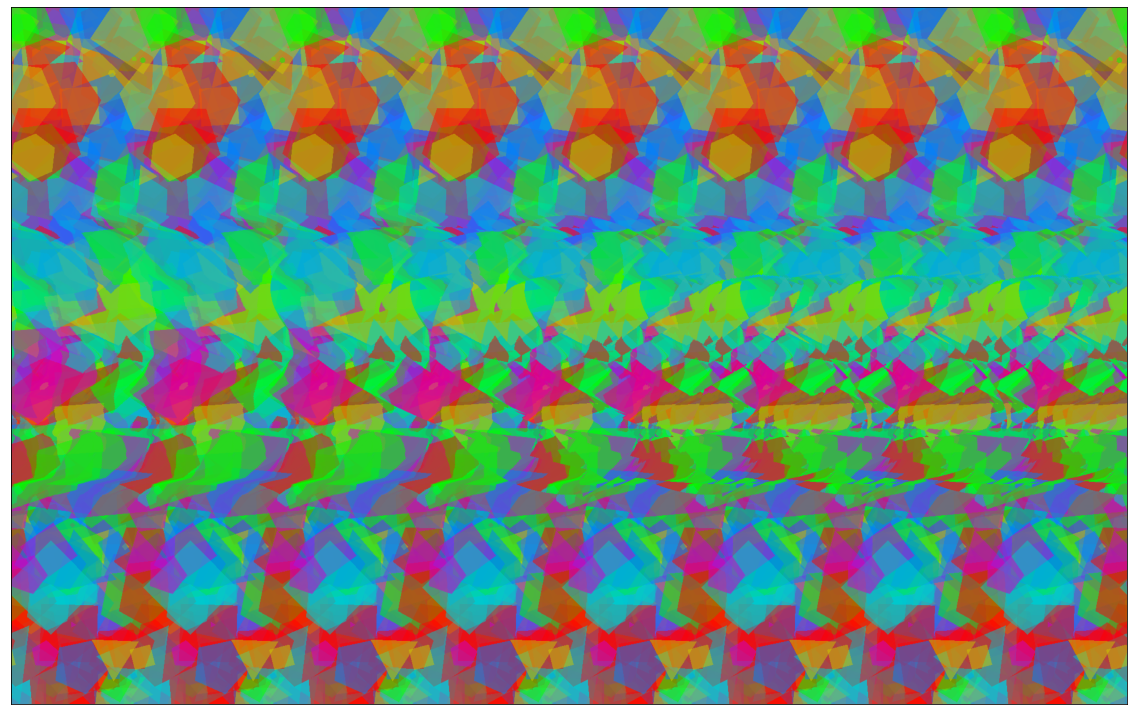

In [117]:
# -- Plots the autostereogram --

xIndices, yIndices = np.indices(imgArr.shape[:2])
yIndicesOffset = encodeDepthInColumnOffsets(depthArrMaster, columnWidth)
imgProcessed = imgValAtVectorized(imgArr, xIndices, yIndices + yIndicesOffset)[:,imgPixPerUnit:-imgPixPerUnit]

plt.figure(figsize=(20,20))
plt.imshow(imgProcessed)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.show()

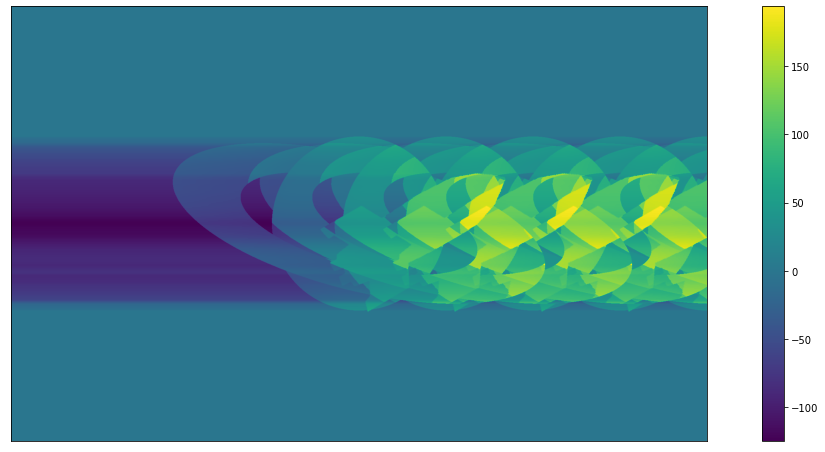

In [118]:
# -- Plots the pixel offsets used to encode the depth map --
# In the autostereogram above, pixels have been moved to the left/right
# (relative to the base image) by the amounts shown below.
# This is how the autostereogram actually gets encoded!

plt.figure(figsize=(20,8))
plt.imshow(yIndicesOffset[:,imgPixPerUnit:-imgPixPerUnit])
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.colorbar()
plt.show()